Removing any residual temporary files created in case of a crash.

In [1]:
import os
if os.path.exists("temp.csv"):
    os.remove("temp.csv")

## Insight for the medical dataset

#### To create the dataframes and files needed for our analysis, make sure that:
    You have full_database.xml under data/medical/ folder, which will represent the XML version of the DrugBank
    You have BindingDB_All.tsv under data/medical/ folder, which will represent the tsv version of the BindingDB

### Imports

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import pandas as pd

from drugbank_XML_drugparser import DrugParser
from drugbank_bindingdb_merger import DrugBank_BindingDB_Merger
from preprocessing import Preprocessing, CleanNumericAtrributesStrategy

%matplotlib inline

%load_ext autoreload
%autoreload 2

### Paths

In [3]:
DATA_PATH = 'data/medical/'
BINDINGDB = DATA_PATH + 'BindingDB_All.tsv'
DRUGBANK_XML = DATA_PATH + 'full_database.xml'
DRUGBANK_CSV = DATA_PATH + 'parsed_DrugBank.csv'
MERGED_CSV = DATA_PATH + 'Merged_Binding_DrugBank_with_Proteins.csv'
MERGED_PARQUET = DATA_PATH + 'merged_dataframe.parquet'
MERGED_PICKLE = DATA_PATH + 'merged_dataframe.pkl'

### Loading the data

In [4]:
def load_BindingDB(file_path):

    ## load the first row to get the number of columns
    df_first_row = pd.read_csv(file_path, sep='\t', nrows=1)

    ## number of columns to use
    df = pd.read_csv(file_path, sep='\t', header=0, usecols=range(df_first_row.shape[1]))
    return df

## Cleaning, filtering and adding Drugbank to BindingDB
Add infos on the filtering that was done and how the merging was done.
- size and the issues regarding that
- missing data (plots or stats)
- explaining the data structure
- what are the columns
- Talk about the overlap ratio of binding DB and drugbank
- Talk about a metric for distance in proteins (in the amino acid description for example)

### Disclaimer : 
The whole filtering and merging does not work on any laptop (low ram) (e.g. m1 macmook air 8GB ram did not work)
Possibility to load the merged dataset (csv) directly.

In [5]:
import gc
if os.path.exists(MERGED_PICKLE):
    print("Merged dataset exists.\n Loading...")

    merged_df = pd.read_pickle(MERGED_PICKLE)

    print("Merged dataset loaded")
elif os.path.exists(MERGED_CSV):
    print("Merged dataset exists.\n Loading...")

    merged_df = pd.read_csv(MERGED_CSV,nrows=1000000)

    print("Merged dataset loaded")
else:
    print("Merged dataset doesn't exists.\n Creating it...")

    if os.path.exists(DRUGBANK_CSV):
        print("parsed_Drugbank exists...")
        print("Loading...")

        drugbank = pd.read_csv(DRUGBANK_CSV, encoding='utf-8')
    else:
        print("parsed_Drugbank doesn't exists...")
        print("Creating parsed_Drugbank.csv")

        drugparser = DrugParser(DRUGBANK_XML)
        drugparser.parse_drugs()
        drugbank = drugparser.save_parsed_drugs(DRUGBANK_CSV, return_df = True)

        print("parsed_Drugbank.csv is created")
        print("DrugBank XML is parsed. \n Loading it ...")

    print("Load Binding DB...")
    bindingDB_df = load_BindingDB(BINDINGDB)

    print("Cleaning Binding DB...")
    preprocessor = Preprocessing(
        [
            CleanNumericAtrributesStrategy(),
        ]
    )
    preprocessed_df = preprocessor.transform(bindingDB_df)

    del bindingDB_df
    gc.collect()
    
    print("Creating merged dataset")
    drugbank_binding_merger = DrugBank_BindingDB_Merger()
    merged_df = drugbank_binding_merger.merge(drugbank, preprocessed_df)
    drugbank_binding_merger.save_merged(MERGED_PICKLE)

    print("Merged dataset is loaded and saved.")

Merged dataset exists.
 Loading...


/var/folders/_h/sv2httr97w1d8pv18rsdrqhc0000gn/T/ipykernel_9722/1315229817.py:11: DtypeWarning: Columns (15,17,21,27,28,32,33,35,36,45,46,47,48,50,51,52,53,54,55,57,58,59,60,62,63,64,65,66,67,69,70,71,72,74,75,76,77,78,79,86,87,88,89,90,91,98,99,100,101,102,103,110,112,113,114,115,122,124,125,126,127,134,135,136,137,138,139,195,196,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,217) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(MERGED_CSV,nrows=1000000)


Merged dataset loaded


### First look into the merged databases.

In [6]:
merged_df.head()

,BindingDB Reactant_set_id,SMILES,Ligand InChI,InChI_Key,BindingDB_ID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,InChI_Key_DrugBank,ChEBI_ID_DrugBank,BindingDB_ID_DrugBank,Unique_DrugBank_ID,Matched_On,drugbank_swissprot_id,name_y,general-function,specific-function,organism
0,1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,InChI=1S/C31H42N2O7/c34-27(35)17-9-3-11-19-32-...,XGEGDSLAQZJGCW-HHGOQMMWSA-N,608734,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,-1.0,...,NaN,NaN,NaN,NaN,NaN,P03367,gag-pol,Zinc ion binding,Gag-Pol polyprotein and Gag polyprotein may re...,HIV-1
1,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,InChI=1S/C31H34N6O3/c38-29-27(17-23-9-3-1-4-10...,UZLMEAPBHYEHAC-UNTBESQGSA-N,22,"(4R,5S,6S,7R)-4,7-dibenzyl-5,6-dihydroxy-1,3-b...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,-1.0,...,NaN,NaN,NaN,NaN,NaN,P03367,gag-pol,Zinc ion binding,Gag-Pol polyprotein and Gag polyprotein may re...,HIV-1
2,3,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,InChI=1S/C29H34N4O3/c34-27-25(16-21-8-3-1-4-9-...,HYNYUFZPPJMPOB-UTWJFGBXSA-N,23,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,-1.0,...,NaN,NaN,NaN,NaN,NaN,P03367,gag-pol,Zinc ion binding,Gag-Pol polyprotein and Gag polyprotein may re...,HIV-1
3,4,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,InChI=1S/C29H40N2O4/c32-18-10-2-1-9-17-30-25(1...,YXVAZXDWVZTGGD-VIJSPRBVSA-N,24,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.80,-1.0,...,NaN,NaN,NaN,NaN,NaN,P03367,gag-pol,Zinc ion binding,Gag-Pol polyprotein and Gag polyprotein may re...,HIV-1
4,5,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,InChI=1S/C28H38N2O4/c31-17-9-3-8-16-29-24(18-2...,WWTSWTPNILRSJX-XDZXDJIYSA-N,25,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,-1.0,...,NaN,NaN,NaN,NaN,NaN,P03367,gag-pol,Zinc ion binding,Gag-Pol polyprotein and Gag polyprotein may re...,HIV-1


In [7]:
for col in merged_df.columns:
    print(col,"                   ",merged_df[col].loc[23409],"\n")

BindingDB Reactant_set_id                     23409 

SMILES                     Nc1cc(ccc1N1CCOCC1=O)N1C[C@H](CNC(=O)c2ccc(Cl)s2)OC1=O 

Ligand InChI                     InChI=1S/C19H19ClN4O5S/c20-16-4-3-15(30-16)18(26)22-8-12-9-24(19(27)29-12)11-1-2-14(13(21)7-11)23-5-6-28-10-17(23)25/h1-4,7,12H,5-6,8-10,21H2,(H,22,26)/t12-/m0/s1 

InChI_Key                     INLXEGDYWOAZAA-LBPRGKRZSA-N 

BindingDB_ID                     12999 

BindingDB Ligand Name                     BAY 59-7939 Analog 14::N-({(5S)-3-[3-Amino-4-(3-oxomorpholin-4-yl)phenyl]-2-oxo-1,3-oxazolidin-5-yl}methyl)-5-chlorothiophene-2-carboxamide::N-{[(5S)-3-[3-amino-4-(3-oxomorpholin-4-yl)phenyl]-2-oxo-1,3-oxazolidin-5-yl]methyl}-5-chlorothiophene-2-carboxamide 

Target Name                     Coagulation factor X 

Target Source Organism According to Curator or DataSource                     Homo sapiens 

Ki (nM)                     -1.0 

IC50 (nM)                     2.5 

Kd (nM)                     -1.0 

EC50 (n

### Initial Cancer related filtering

In [8]:
cancer_keywords = [
    "cancer", "tumor", "carcinoma", "neoplasm", "malignancy", "metastasis", "oncology",
    "sarcoma", "adenocarcinoma", "lymphoma", "leukemia", "myeloma", "breast cancer",
    "lung cancer", "prostate cancer", "colon cancer", "rectal cancer", "colorectal cancer",
    "skin cancer", "melanoma", "bladder cancer", "kidney cancer", "renal cancer",
    "pancreatic cancer", "ovarian cancer", "cervical cancer", "uterine cancer", "thyroid cancer",
    "liver cancer", "gastric cancer", "stomach cancer", "esophageal cancer", "brain cancer",
    "glioma", "astrocytoma", "neuroblastoma", "endometrial cancer", "dysplasia", "hyperplasia",
    "leukoplakia", "adenoma", "metastases", "carcinoma in situ", "anaplastic",
    "fibrosarcoma", "osteosarcoma", "mesothelioma", "chemotherapy", "radiotherapy",
    "immunotherapy", "metastasize", "malignant", "benign", "stage", "staging"
    "tumor suppressor", "oncogene", "palliative care",
]
filtered_df_with_target_name = merged_df[merged_df[["Target Name", "UniProt (SwissProt) Entry Name of Target Chain"]].map(lambda x: any(keyword in str(x).lower() for keyword in cancer_keywords)).any(axis=1)]

In [9]:
keyword_mathis = pd.read_csv("data/medical/keywords_cancer.csv")


In [12]:
# filtered_df = merged_df[merged_df['BindingDB Ligand Name'].str.contains('|'.join(keyword_mathis.loc[keyword_mathis["Type"]=="Molecule","Name"]), case=False, na = False)]
incomplete_keywords_df = pd.read_csv("data/medical/incomplete_ligand_id_cancer.csv")

filtered_df = merged_df[merged_df["Ligand InChI"].isin(incomplete_keywords_df["Ligand InChI"])]


In [13]:
filtered_df

,BindingDB Reactant_set_id,SMILES,Ligand InChI,InChI_Key,BindingDB_ID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,InChI_Key_DrugBank,ChEBI_ID_DrugBank,BindingDB_ID_DrugBank,Unique_DrugBank_ID,Matched_On,drugbank_swissprot_id,name_y,general-function,specific-function,organism
0,1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,InChI=1S/C31H42N2O7/c34-27(35)17-9-3-11-19-32-...,XGEGDSLAQZJGCW-HHGOQMMWSA-N,608734,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,-1.0,...,NaN,NaN,NaN,NaN,NaN,P03367,gag-pol,Zinc ion binding,Gag-Pol polyprotein and Gag polyprotein may re...,HIV-1
1,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,InChI=1S/C31H34N6O3/c38-29-27(17-23-9-3-1-4-10...,UZLMEAPBHYEHAC-UNTBESQGSA-N,22,"(4R,5S,6S,7R)-4,7-dibenzyl-5,6-dihydroxy-1,3-b...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,-1.0,...,NaN,NaN,NaN,NaN,NaN,P03367,gag-pol,Zinc ion binding,Gag-Pol polyprotein and Gag polyprotein may re...,HIV-1
2,3,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,InChI=1S/C29H34N4O3/c34-27-25(16-21-8-3-1-4-9-...,HYNYUFZPPJMPOB-UTWJFGBXSA-N,23,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,-1.0,...,NaN,NaN,NaN,NaN,NaN,P03367,gag-pol,Zinc ion binding,Gag-Pol polyprotein and Gag polyprotein may re...,HIV-1
3,4,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,InChI=1S/C29H40N2O4/c32-18-10-2-1-9-17-30-25(1...,YXVAZXDWVZTGGD-VIJSPRBVSA-N,24,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.80,-1.0,...,NaN,NaN,NaN,NaN,NaN,P03367,gag-pol,Zinc ion binding,Gag-Pol polyprotein and Gag polyprotein may re...,HIV-1
4,5,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,InChI=1S/C28H38N2O4/c31-17-9-3-8-16-29-24(18-2...,WWTSWTPNILRSJX-XDZXDJIYSA-N,25,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,-1.0,...,NaN,NaN,NaN,NaN,NaN,P03367,gag-pol,Zinc ion binding,Gag-Pol polyprotein and Gag polyprotein may re...,HIV-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1023311,CCn1cc(cn1)-c1cc2c3n(-c4ncccc4F)c(=O)n(C)c3cnc...,InChI=1S/C22H19FN6O2/c1-4-28-12-13(10-26-28)14...,FMTZTJBUEHSMKS-UHFFFAOYSA-N,418456,8-(1-Ethyl-1H-pyrazol-4-yl)- 1-(3-fluoropyridi...,"Phosphatidylinositol 4,5-bisphosphate 3-kinase...",Homo sapiens,-1.00,30000.0,...,NaN,NaN,NaN,NaN,NaN,P48736,PIK3CG,Protein serine/threonine kinase activity,Phosphoinositide-3-kinase (PI3K) that phosphor...,Humans
999996,1023312,CCn1cc(cn1)-c1cc2c3n(-c4ncccc4F)c(=O)n(C)c3cnc...,InChI=1S/C22H19FN6O2/c1-4-28-12-13(10-26-28)14...,FMTZTJBUEHSMKS-UHFFFAOYSA-N,418456,8-(1-Ethyl-1H-pyrazol-4-yl)- 1-(3-fluoropyridi...,Serine/threonine-protein kinase mTOR,Homo sapiens,-1.00,30000.0,...,NaN,NaN,NaN,NaN,NaN,P42345,MTOR,Tfiiic-class transcription factor binding,Serine/threonine protein kinase which is a cen...,Humans
999997,1023313,CCc1cncc(F)c1-n1c2c(cnc3cc(OC)c(cc23)-c2cnn(CC...,InChI=1S/C24H23FN6O2/c1-5-14-9-26-11-18(25)22(...,JRPOQJULIAPLDC-UHFFFAOYSA-N,418457,1-(3-Ethyl-5-fluoropyridin-4- yl)-8-(1-ethyl-1...,Serine-protein kinase ATM,NaN,-1.00,1.0,...,NaN,NaN,NaN,NaN,NaN,Q13315,ATM,Protein serine/threonine kinase activity,Serine/threonine protein kinase which activate...,Humans
999998,1023314,CCc1cncc(F)c1-n1c2c(cnc3cc(OC)c(cc23)-c2cnn(CC...,InChI=1S/C24H23FN6O2/c1-5-14-9-26-11-18(25)22(...,JRPOQJULIAPLDC-UHFFFAOYSA-N,418457,1-(3-Ethyl-5-fluoropyridin-4- yl)-8-(1-ethyl-1...,"Phosphatidylinositol 4,5-bisphosphate 3-kinase...",Homo sapiens,-1.00,30000.0,...,NaN,NaN,NaN,NaN,NaN,P42336,PIK3CA,Protein serine/threonine kinase activity,Phosphoinositide-3-kinase (PI3K) that phosphor...,Humans


In [15]:
unique_cancer_related_proteins = filtered_df_with_target_name["Target Name"].unique()
unique_cancer_related_proteins_mathis = filtered_df["Target Name"].unique()


print(f"number of different cancer related proteins: {len(filtered_df_with_target_name)}")
print(f"number of different cancer related proteins: {len(unique_cancer_related_proteins_mathis)}")

number of different cancer related proteins: 40852
number of different cancer related proteins: 2745


#### Further steps in cancer related search: 
Creating a longer list keywords to get a more complete list of datapoints to do our analysis. This list would contain : 
- active molecules used for cancer treatment
- cancer related proteins
- cancer types
- cancer treatment categories.

#### Just human as source organism

In [16]:
filtered_df_human = filtered_df_with_target_name[filtered_df_with_target_name[["Target Source Organism According to Curator or DataSource", "UniProt (SwissProt) Entry Name of Target Chain"]].map(lambda x: "human" in str(x).lower()).any(axis=1)]

In [17]:
len(filtered_df_human)

40518

# Mutations

# Statistical analysis
## First explorations
- Correlation between metrics of biding affinity, dosage, etc
- Possibly trying to see some groupings of data points (similarity in structure, metrics, types of disease being fought, ...)


In [18]:
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats import diagnostic
from scipy import stats


In [19]:
print(diagnostic.kstest_normal(merged_df['Ki (nM)'].values, dist = 'norm'))
print(diagnostic.kstest_normal(merged_df['Ki (nM)'].values, dist = 'exp'))
print(diagnostic.kstest_normal(merged_df['IC50 (nM)'].values, dist = 'norm'))
print(diagnostic.kstest_normal(merged_df['IC50 (nM)'].values, dist = 'exp'))
print(diagnostic.kstest_normal(merged_df['Kd (nM)'].values, dist = 'norm'))
print(diagnostic.kstest_normal(merged_df['Kd (nM)'].values, dist = 'exp'))
print(diagnostic.kstest_normal(merged_df['EC50 (nM)'].values, dist = 'norm'))
print(diagnostic.kstest_normal(merged_df['EC50 (nM)'].values, dist = 'exp'))

(0.49578227094119665, 0.0009999999999998899)
(0.936556930957426, 0.0009999999999998899)
(0.49772148537006844, 0.0009999999999998899)
(0.8991272050818973, 0.0009999999999998899)
(0.49784221547077057, 0.0009999999999998899)
(0.9891876814301329, 0.0009999999999998899)
(0.4993121329858857, 0.0009999999999998899)
(0.9276488014594837, 0.0009999999999998899)


Not a normal or exponential distribution

#### Keeping only columns of interest and rows with non empty metrics

In [35]:
merged_df_test = filtered_df.dropna(subset=['IC50 (nM)', 'Ki (nM)','Kd (nM)','EC50 (nM)','pH','Temp (C)'])
merged_df_test = merged_df_test.loc[(merged_df_test["IC50 (nM)"]>=0) | (merged_df_test["EC50 (nM)"]>=0)]
merged_df_test = merged_df_test.loc[(merged_df_test["Ki (nM)"]>=0) | (merged_df_test["Kd (nM)"]>=0)]
merged_df_test = merged_df_test.loc[(merged_df_test["pH"]>=0)]


merged_df_test = merged_df_test[[
    "BindingDB Reactant_set_id",
    "SMILES_BindingDB",
    "Ligand InChI",
    "InChI_Key_BindingDB",
    "BindingDB_ID_BindingDB",
    "BindingDB Ligand Name",
    "Target Name",
    "Target Source Organism According to Curator or DataSource",
    "Ki (nM)",
    "IC50 (nM)",
    "Kd (nM)",
    "EC50 (nM)",
    "kon (M-1-s-1)",
    "koff (s-1)",
    "pH",
    "Temp (C)",
    "Curation/DataSource",
    "Article DOI",
    "BindingDB Entry DOI",
    "PMID",
    "PubChem AID",
    "Patent Number",
    "Authors",
    "Institution",
    "Link to Ligand in BindingDB",
    "Link to Target in BindingDB",
    "Link to Ligand-Target Pair in BindingDB",
    "Ligand HET ID in PDB",
    "PDB ID(s) for Ligand-Target Complex",
    "PubChem_CID",
    "PubChem SID",
    "ChEBI_ID_BindingDB",
    "ChEMBL_ID_BindingDB",
    "DrugBank_ID",
    "IUPHAR_GRAC ID of Ligand",
    "KEGG_ID",
    "ZINC_ID",
    "Number of Protein Chains in Target (>1 implies a multichain complex)",
    "BindingDB Target Chain Sequence",
    "PDB ID(s) of Target Chain",
    "Unique_ID",
    "unii",
    "toxicity",
    "class_kingdom",
    "class_superclass",
    "synonyms",
    "categories",
    "patent_approved",
    "interaction",
    "ChEMBL_ID_DrugBank",
    "SMILES_DrugBank",
    "InChI_Key_DrugBank",
    "ChEBI_ID_DrugBank",
    "BindingDB_ID_DrugBank",
    "Matched_On"]]


In [37]:
merged_df_test[['IC50 (nM)', 'Ki (nM)','Kd (nM)','EC50 (nM)','pH','Temp (C)']]

,IC50 (nM),Ki (nM),Kd (nM),EC50 (nM),pH,Temp (C)
767,4.000,0.031,-1.0,-1.0,5.50,37.00 C
768,10.000,0.130,-1.0,-1.0,5.50,37.00 C
1024,125.000,100.000,-1.0,-1.0,5.50,37.00 C
1322,2600.000,70.000,-1.0,-1.0,6.25,37.00 C
1325,4400.000,41.000,-1.0,-1.0,6.25,37.00 C
...,...,...,...,...,...,...
410011,5.684,8.304,-1.0,-1.0,7.40,25.00 C
410013,2.104,1.584,-1.0,-1.0,7.40,25.00 C
411783,13700.000,2640.000,-1.0,-1.0,7.40,25.00 C
411784,22100.000,4250.000,-1.0,-1.0,7.40,25.00 C


In [38]:
mod = smf.ols(formula='Q("IC50 (nM)") ~ Q("Ki (nM)")', data=merged_df_test)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Q("IC50 (nM)")   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     2080.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):          3.86e-204
Time:                        16:42:37   Log-Likelihood:                -8605.9
No. Observations:                 648   AIC:                         1.722e+04
Df Residuals:                     646   BIC:                         1.722e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.696e+04   5584.967      4.827   

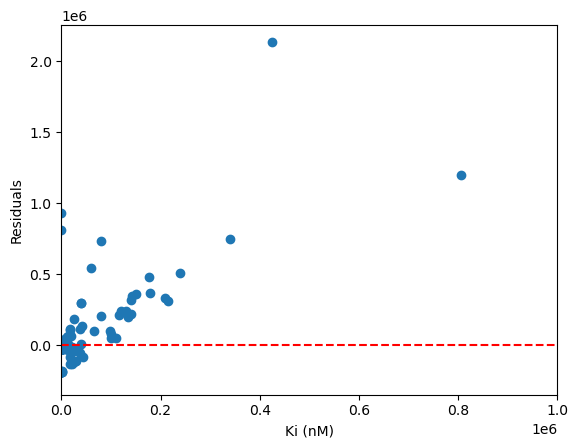

In [60]:
import matplotlib.pyplot as plt
residuals = res.resid
plt.scatter(merged_df_test['Ki (nM)'], residuals)
plt.xlim([0,1e6])

plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Ki (nM)')
plt.ylabel('Residuals')
plt.show()

In [42]:
merged_df_test['log_IC50'] = np.log(merged_df_test['IC50 (nM)'])
merged_df_test['log_Ki'] = np.log(merged_df_test['Ki (nM)'])
mod = smf.ols(formula='log_IC50 ~ log_Ki', data=merged_df_test)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               log_IC50   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     1154.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):          1.52e-119
Time:                        16:44:45   Log-Likelihood:                -831.47
No. Observations:                 399   AIC:                             1667.
Df Residuals:                     397   BIC:                             1675.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8381      0.134     21.132      0.0

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: x and y must be the same size

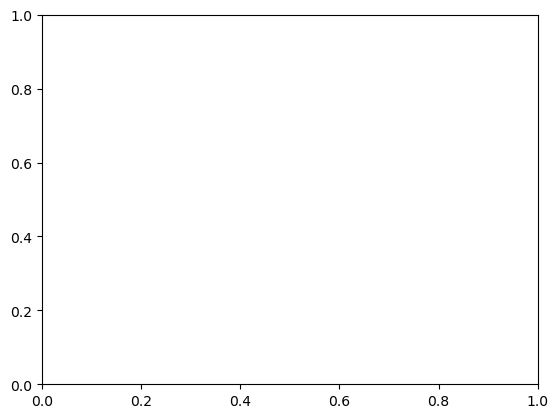

In [43]:
import matplotlib.pyplot as plt
residuals = res.resid
plt.scatter(merged_df_test['Ki (nM)'], residuals)
plt.xlim([0.1,1.1])
plt.xlabel('Ki (nM)')
plt.ylabel('Residuals')
plt.show()

In [44]:
mod = smf.ols(formula='Q("IC50 (nM)") ~ Q("Ki (nM)") + Q("Temp (C)") + Q("pH")', data=merged_df_test)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         Q("IC50 (nM)")   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     192.9
Date:                Fri, 15 Nov 2024   Prob (F-statistic):          1.45e-202
Time:                        16:44:52   Log-Likelihood:                -8574.8
No. Observations:                 648   AIC:                         1.718e+04
Df Residuals:                     635   BIC:                         1.723e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

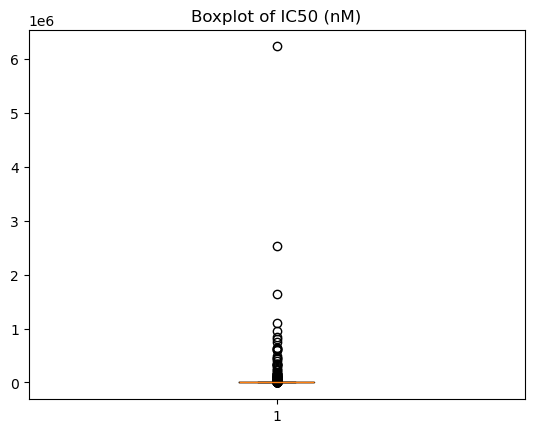

In [54]:
plt.boxplot(merged_df_test['IC50 (nM)'])
# plt.ylim([1e-1,10**9])
# plt.yscale("log")

plt.title('Boxplot of IC50 (nM)')
plt.show()
